In [117]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Input
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
from tensorflow.keras.layers import BatchNormalization, Reshape


In [118]:
#positional encoding function
def positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        # 1. Calculate the PE matrix once when the layer is initialized
        self.positional_encoding_matrix = positional_encoding(sequence_length, embed_dim)

    def call(self, inputs):
        # 2. Add the PE matrix to the input tensor (the output of the Dense layer)
        # Broadcasting handles the batch dimension addition automatically
        return inputs + self.positional_encoding_matrix[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'sequence_length': self.sequence_length,
            'embed_dim': self.embed_dim,
        })
        return config

In [119]:
tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)

<MultiHeadAttention name=multi_head_attention_33, built=False>

In [120]:
#feed forward network
ffn = tf.keras.Sequential([
    tf.keras.layers.Dense(ff_dim, activation="relu"),
    tf.keras.layers.Dense(embed_dim),
])

In [121]:
def load_ecg_data(normal_path, abnormal_path):
    """Load and combine normal and abnormal ECG data"""
    normal_df = pd.read_csv(normal_path, header=None)
    abnormal_df = pd.read_csv(abnormal_path, header=None)
    
    # Combine datasets
    df = pd.concat([normal_df, abnormal_df], axis=0).reset_index(drop=True)
    
    # Separate features and labels
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    print(f"Loaded {len(X)} ECG samples")
    print(f"Normal: {np.sum(y == 0)}, Abnormal: {np.sum(y == 1)}")
    
    return X, y

In [122]:
X, y = load_ecg_data('ptbdb_normal.csv', 'ptbdb_abnormal.csv')

Loaded 14552 ECG samples
Normal: 4046, Abnormal: 10506


In [123]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoderBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        # 1. Multi-Head Attention Sub-layer
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)
        
        # 2. Feed-Forward Network (FFN) Sub-layer
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim)
        ])
        
        # 3. Normalization and Dropout Layers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=None):
        x = self.layernorm1(inputs) 
        # Process with attention
        attn_output = self.att(x, x) 
        attn_output = self.dropout1(attn_output, training=training)
        # Residual Connection: Add original inputs back to the processed normalized signal
        out1 = inputs + attn_output

        # --- 2. Feed-Forward Block (Pre-LN) ---
        # Normalize the result of the first block
        y = self.layernorm2(out1)
        # Process with FFN
        ffn_output = self.ffn(y)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        return out1 + ffn_output

In [124]:
def augment_time_shift(X, max_shift=10):
    X_shifted = np.empty_like(X)
    for i in range(X.shape[0]):
        # Choose a random shift value for this specific sample
        random_shift = np.random.randint(-max_shift, max_shift)
        X_shifted[i] = np.roll(X[i], shift=random_shift)
    return X_shifted

In [125]:
# 1. Create shifted data
X_shifted = augment_time_shift(X, max_shift=10)

# 2. Combine with original (Now you have 28,000 samples!)
X_combined = np.concatenate([X, X_shifted], axis=0)
y_combined = np.concatenate([y, y], axis=0)

# 3. Shuffle the combined data so the model doesn't see all originals then all shifts
indices = np.random.permutation(len(X_combined))
X_final = X_combined[indices]
y_final = y_combined[indices]

In [126]:
x_train, x_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2)

In [127]:
x_train_scaled = StandardScaler().fit_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test_scaled = StandardScaler().fit_transform(x_test.reshape(-1, 1)).reshape(x_test.shape)

In [ ]:
sequence_length = 187
embed_dim = 64
num_heads = 8
ff_dim = 128
num_transformer_blocks = 4
dropout_rate = 0.1
num_classes = 1 # Example value: replace with your actual number of ECG categories

# 1. Define the Input Tensor
inputs = Input(shape=(sequence_length,), name="ECG_Input")

# 2. Initial Embedding/Projection
x = Reshape((sequence_length, 1))(inputs) # (Batch, 187, 1)
x = tf.keras.layers.Conv1D(filters=embed_dim, kernel_size=3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
# 3. Positional Encoding
x = PositionalEmbedding(sequence_length, embed_dim)(x)

#Transformer blocks
for i in range(num_transformer_blocks):
    x = TransformerEncoderBlock(
        embed_dim=embed_dim, 
        num_heads=num_heads, 
        ff_dim=ff_dim, 
        rate=dropout_rate, 
        name=f"Encoder_Block_{i+1}"
    )(x)
    
# 5. Final Classification Head
x = GlobalAveragePooling1D()(x) # (Batch, 64)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

# 6. Create the full Model object using the Functional API
model = Model(inputs=inputs, outputs=outputs)

In [129]:
cb = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
]

In [133]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [131]:
history = model.fit(x_train_scaled, y_train, validation_data=(x_test_scaled, y_test), callbacks=cb, epochs=200, batch_size=32)

Epoch 1/200
728/728 ━━━━━━━━━━━━━━━━━━━━ 115s 147ms/step - accuracy: 0.6680 - loss: 0.6512 - val_accuracy: 0.7301 - val_loss: 0.5181
Epoch 2/200
728/728 ━━━━━━━━━━━━━━━━━━━━ 120s 165ms/step - accuracy: 0.7189 - loss: 0.5541 - val_accuracy: 0.7385 - val_loss: 0.5032
Epoch 3/200
728/728 ━━━━━━━━━━━━━━━━━━━━ 118s 162ms/step - accuracy: 0.7347 - loss: 0.5235 - val_accuracy: 0.7523 - val_loss: 0.4851
Epoch 4/200
728/728 ━━━━━━━━━━━━━━━━━━━━ 122s 168ms/step - accuracy: 0.7513 - loss: 0.5010 - val_accuracy: 0.7784 - val_loss: 0.4635
Epoch 5/200
728/728 ━━━━━━━━━━━━━━━━━━━━ 131s 180ms/step - accuracy: 0.7700 - loss: 0.4759 - val_accuracy: 0.7985 - val_loss: 0.4359
Epoch 6/200
728/728 ━━━━━━━━━━━━━━━━━━━━ 135s 186ms/step - accuracy: 0.7930 - loss: 0.4483 - val_accuracy: 0.8134 - val_loss: 0.4066
Epoch 7/200
728/728 ━━━━━━━━━━━━━━━━━━━━ 138s 190ms/step - accuracy: 0.8039 - loss: 0.4232 - val_accuracy: 0.8253 - val_loss: 0.3810
Epoch 8/200
728/728 ━━━━━━━━━━━━━━━━━━━━ 136s 187ms/step - accuracy: 

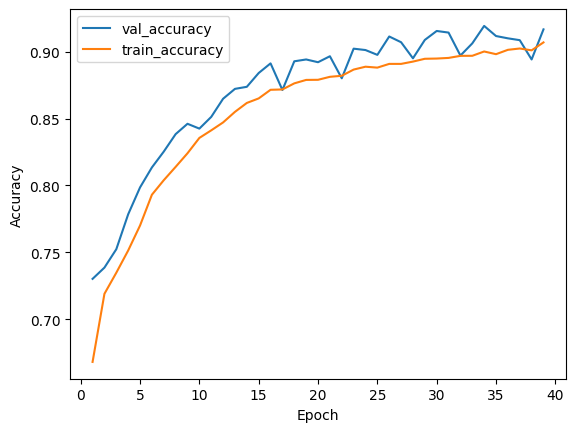

In [135]:
ranges = range(1, len(history.history['accuracy']) + 1)
plt.plot(ranges, history.history['val_accuracy'], label='val_accuracy')
plt.plot(ranges, history.history['accuracy'], label='train_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [141]:
max(history.history['val_accuracy'])

0.9192578792572021